# DECO SCRIPT :
- Version : 13 / 04 / 2024 (13th April 2024)
- Author : Benoit Pierson
- Mail : benoitmarc.pierson@gmail.com

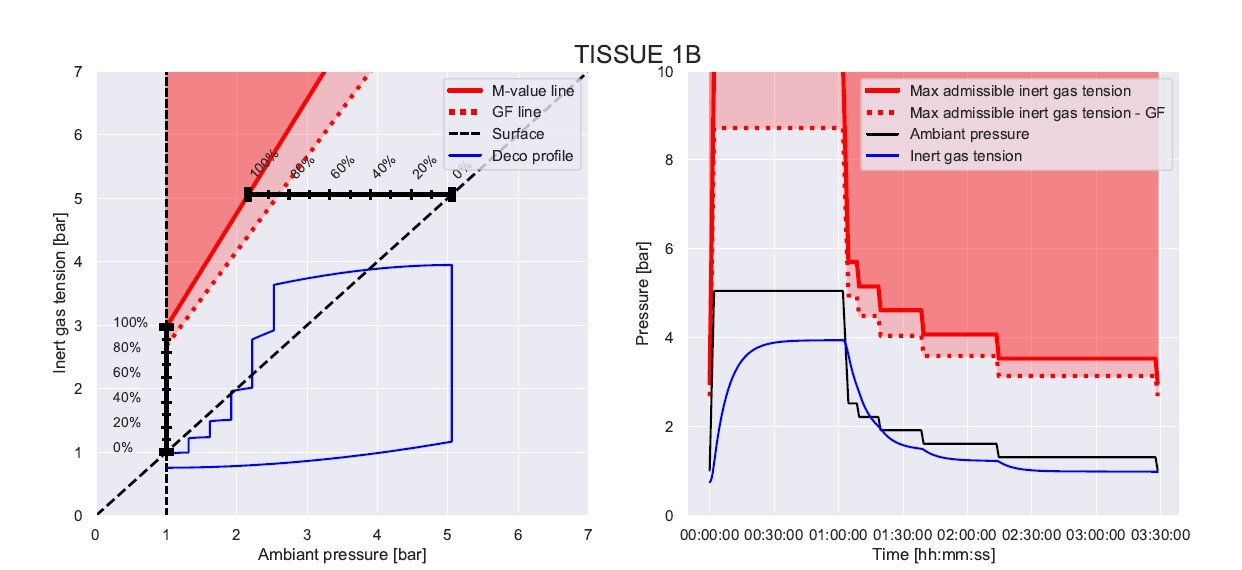

# SCOPE : 

- The aim of this work is to give an overview of the methodology used by a diving computer, not to replace it or to plan a dive !

- This is a non-certifies work. This work has not been checked properly (no peer review process) as it has to be for a real usage

- This notebook is useful if you want to visualize tissues saturations along time for a given dive (see at the end of this notebook)

# HYPOTHESIS : 
- We consider Buhlmann ZHL16-C model for M-values and half-times of 16 tissues
- We let the user choose the proper gradient factor he wants to use
- For the first tissue, we consider 1b
- Speed at descent is 20m/s
- Speed ascent is 10m/s to the first deco stop, 3m/s between deco stops, 3m/s to the surface (high considering common used values ~ 1m/s in last meters of ascent

In [15]:
from datetime import datetime, timedelta
import matplotlib.ticker as mtick
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme()

# 1 - Definition of constants

In [16]:
rho_water = 1030.0 # Water density [kg/m**3]
p_water_vapor = 0.0627 # Water vapor pressure in lungs [bar]
p_atm_sea_level = 1.01325 # Ambiant pressure at sea level [bar]
g = 9.81 # gravity [m*s**-2]

# 2 - Definition of functions

In [17]:
def get_M_values(file_path):
    df_M_Values = pd.read_csv(file_path, sep = ";")
    M_values = {}
    for i in range(len(df_M_Values)):
        cell = df_M_Values.iloc[i]['Cell']
        HT = df_M_Values.iloc[i]['Half-time [sec]']
        M0 = df_M_Values.iloc[i]['M0']
        M_slope = df_M_Values.iloc[i]['M_slope']
        M_values[cell] = {}
        M_values[cell]["HT"] = HT
        M_values[cell]["M0"] = M0
        M_values[cell]["M_Slope"] = M_slope       
    return M_values



def define_dive_profile(depth, diving_time, desc_speed):
    descent_time = depth / desc_speed    
    start_time = datetime(1900, 1, 1, 0, 0, 0)
    bottom_arrival_time = start_time + timedelta(seconds = descent_time)
    end_time = bottom_arrival_time + timedelta(minutes = diving_time)
    df = pd.DataFrame({
        'Time' : [start_time, bottom_arrival_time, end_time],
        'Depth [m]'  : [0., depth, depth]})
    return df
    


def shreiner(k, R, P0, Pi0, t):
    # k : half-time constant = ln2/half-time [sec**-1]
    # R : rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
    # Pi0 : initial inspired (alveolar) inert gas pressure [bar]
    # P0 : initial compartment inert gas pressure [bar]
    P = Pi0 + R * (t - (1/k)) - (Pi0 - P0 - (R/k)) * np.exp(-k*t)
    return P



def calculate_cell_saturation(df):
    nb_steps = len(df)
    time_steps = list(df["Time"])
    depth_steps = list(df["Depth [m]"])
    for cell in M_values.keys():
        HT = M_values[cell]['HT']
        k = np.log(2) / HT
        cell_saturation_along_times = list()
        for i in range(nb_steps):
            if (i == 0): 
                cell_saturation_along_times.append(0.79 * (p_atm_sea_level - p_water_vapor))
            else:
                P0 = cell_saturation_along_times[-1] # initial compartment inert gas pressure [bar]
                Pamb = p_atm_sea_level + (depth_steps[i-1] * rho_water * g) / 1E5
                Pi0 = N2Part * (Pamb - p_water_vapor) # initial inspired (alveolar) inert gas pressure [bar]
                depth_delta = depth_steps[i] - depth_steps[i-1]
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
                desc_speed = depth_delta / time_delta
                R = N2Part * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
                t = time_delta # time
                cell_saturation_along_times.append(shreiner(k, R, P0, Pi0, t))            
        df['pN2_cell_' + cell + ' [bar]'] = cell_saturation_along_times
    return df



def define_possible_deco_stops(df):
    possible_deco_stops = [*range(0, 1 + int(np.floor(df['Depth [m]'].max())), 3)]
    return possible_deco_stops


def pressure_at_depth(depth):
    return p_atm_sea_level + (rho_water * g * depth) / 1E5



def get_next_deco_stop(df, M_values, possible_deco_stops, GF_max_adm, ascent_speed):
    is_deco_stop_admissible = False
    for deco_stop_candidate in possible_deco_stops:
        is_deco_stop_admissible = True
        for cell in M_values.keys():         
            M0 = M_values[cell]['M0']
            M_slope = M_values[cell]['M_Slope']
            p_amb_stop_candidate = pressure_at_depth(deco_stop_candidate)
            M_value = M0 + M_slope * (p_amb_stop_candidate - p_atm_sea_level)
            max_adm_inert_gas_pressure = (1 - GF_max_adm) * p_amb_stop_candidate + GF_max_adm * M_value
            p_inert_gas_candidate = calculate_cell_saturation_after_ascent(df, cell, deco_stop_candidate, ascent_speed)
            if (p_inert_gas_candidate > max_adm_inert_gas_pressure):
                is_deco_stop_admissible = False 
        if (is_deco_stop_admissible):
            break
    return deco_stop_candidate

            
def calculate_cell_saturation_after_ascent(df, cell, depth_stop, ascent_speed):
    depth_current = df['Depth [m]'].values[-1]
    HT = M_values[cell]['HT']
    k = np.log(2) / HT
    P0 = df['pN2_cell_' + str(cell) + ' [bar]'].values[-1]
    Pamb = p_atm_sea_level + (depth_current * rho_water * g) / 1E5
    Pi0 = N2Part * (Pamb - p_water_vapor)
    R = - N2Part * ascent_speed * ((rho_water * g) / 1E5)
    t = np.abs(depth_current - depth_stop) / ascent_speed
    return shreiner(k, R, P0, Pi0, t)



def interpolate_max_GF_at_depth(depth, first_deco_depth, GF_low, GF_high):
    return GF_high - ((GF_high - GF_low) * depth / first_deco_depth)


def calculate_cell_GF(cell, depth, inert_gas_tension):
    M0 = M_values[cell]['M0']
    M_slope = M_values[cell]['M_Slope']
    ambiant_pressure = pressure_at_depth(depth)
    M_value = M0 + M_slope * (ambiant_pressure - p_atm_sea_level)
    return max(0, (inert_gas_tension - ambiant_pressure) / (M_value - ambiant_pressure))


def calculate_ascent_profile(df):
    ascent_beginning = True
    
    while (df['Depth [m]'].values[-1] != 0):
    
        if (ascent_beginning):
            first_deco_stop = get_next_deco_stop(df, M_values, possible_deco_stops, GF_low, ascent_speed)
            depth = first_deco_stop
            ascent_duration = np.abs(first_deco_stop - df['Depth [m]'].values[-1]) / ascent_speed
            time = df['Time'].values[-1] + np.timedelta64(int(np.ceil(ascent_duration)), 's')
            df = pd.concat([df, pd.DataFrame([{'Time' : time, 'Depth [m]' : depth}])], ignore_index = True)
            df = calculate_cell_saturation(df)
            ascent_beginning = False
        
        else:
            depth = df['Depth [m]'].values[-1]
            GF_max = interpolate_max_GF_at_depth(depth, first_deco_stop, GF_low, GF_high)
            next_depth = get_next_deco_stop(df, M_values, possible_deco_stops, GF_max, ascent_speed_between_stops)
        
            if (depth == next_depth):
                time = df['Time'].values[-1] + np.timedelta64(60, 's')
                df = pd.concat([df, pd.DataFrame([{'Time' : time, 'Depth [m]' : depth}])], ignore_index = True)
                df = calculate_cell_saturation(df)
            
            else:
                ascent_duration = 3 / ascent_speed_between_stops
                time = df['Time'].values[-1] + np.timedelta64(int(np.ceil(ascent_duration)), 's')
                df = pd.concat([df, pd.DataFrame([{'Time' : time, 'Depth [m]' : depth - 3}])], ignore_index = True)
                df = calculate_cell_saturation(df)
    
    df_g = df.iloc[1:].groupby(['Depth [m]']).agg({'Time' : ['min', 'max']}).reset_index(drop = False)
    df_g.columns = ['Depth [m]', 'Time - min', 'Time - max']
    df_g['Duration at depth'] = ((df_g['Time - max'] - df_g['Time - min']).dt.total_seconds() / 60).astype('int')
    df_g = df_g.sort_values(by = "Time - min").reset_index(drop = True)
    df_g['Ascent duration'] = 0.
    for i in range(1, len(df_g)):
        df_g['Ascent duration'].iloc[i] = np.ceil((df_g['Time - min'].iloc[i] - df_g['Time - max'].iloc[i-1]).total_seconds() / 60)
    df_g['Ascent duration'] = df_g['Ascent duration'].astype('int')
    df_g['Time - min'] = df_g['Time - min'].dt.time
    df_g['Time - max'] = df_g['Time - max'].dt.time
    df_g = df_g[['Depth [m]', 'Time - min', 'Time - max', 'Ascent duration', 'Duration at depth']]
    
    return df, df_g, first_deco_stop


def get_max_depth_for_deco_mix(max_PPO2, O2_part):
    return ((max_PPO2 / O2_part) - 1) * 10



def calculate_cells_saturation_during_deco(max_PPO2, O2_part_Deco):
    nb_steps = len(df2)
    time_steps = list(df2["Time"])
    depth_steps = list(df2["Depth [m]"])
    max_depth_deco_mix = get_max_depth_for_deco_mix(max_PPO2, O2Part_Deco)
    
    for i in range(len(df2)):       
        depth = depth_steps[len(df2)-i-1]    
        if (depth > max_depth_deco_mix):
            first_timestep_deco = time_steps[len(df2)-i-1]
            break
                
    for cell in M_values.keys():
        #print(" > Cpt ° " + cpt)
        HT = M_values[cell]['HT']
        k = np.log(2) / HT # k = half-time constant = ln2/half-time
        tissue_time_sat = []
        for i in range(nb_steps):
            if (i == 0):
                tissue_time_sat.append(0.79 * (p_atm_sea_level - p_water_vapor))
            else:
                P0 = tissue_time_sat[-1] # initial compartment inert gas pressure [bar]
                Pamb = p_atm_sea_level + (depth_steps[i-1] * rho_water * g) / 1E5
                depth_delta = depth_steps[i] - depth_steps[i-1]
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
                desc_speed = depth_delta / time_delta
                
                if ((time_steps[i] < first_timestep_deco) and (depth_steps[i] > 0.001)):
                    Pi0 = N2Part * (Pamb - p_water_vapor) # initial inspired (alveolar) inert gas pressure [bar]
                    R = N2Part * desc_speed * (rho_water * g) / 1E5 # R = rate of change in inspired gas pressure with change in ambient pressure
                
                elif ((time_steps[i] >= first_timestep_deco) and (depth_steps[i] > 0.001)):
                    Pi0 = (1.0 - O2Part_Deco) * (Pamb - p_water_vapor) # initial inspired (alveolar) inert gas pressure [bar]
                    R = (1.0 - O2Part_Deco) * (desc_speed * rho_water * g) / 1E5 # R = rate of change in inspired gas pressure with change in ambient pressure
                
                else:
                    Pi0 = 0.79 * (Pamb - p_water_vapor) # initial inspired (alveolar) inert gas pressure [bar]
                    R = 0.79 * desc_speed * (rho_water * g) / 1E5 # R = rate of change in inspired gas pressure with change in ambient pressure

                t = time_delta # time
                tissue_time_sat.append(shreiner(k, R, P0, Pi0, t))
            
        df2['pN2_cell_' + cell + ' [bar]_deco'] = tissue_time_sat
    return df2    

# 3 - Deco profile calculation

In [18]:
GF_low = 0.9  # %
GF_high = 0.9  # %
N2Part = 0.79  # %
descent_speed = 20 / 60  # m / sec
ascent_speed = 10 / 60  # m / sec
ascent_speed_between_stops = 3 / 60  # m / sec
time_after_dive = 15  # min
max_PPO2 = 1.6  # bar
O2Part_Deco = 1.0  # bar

M_values = get_M_values("Buhlmann_Zh-L16C_M-values.csv")
df = define_dive_profile(depth = 50, diving_time = 30, desc_speed = descent_speed)
df = calculate_cell_saturation(df)
possible_deco_stops = define_possible_deco_stops(df)
df, deco_planner, first_deco_stop = calculate_ascent_profile(df)
start = df['Time'].min()
end = df['Time'].max()
nb_secs = int((df['Time'].max() - df['Time'].min()).total_seconds()) + 1
times = [start + np.timedelta64(i, 's') for i in range(nb_secs)]
df2 = pd.DataFrame({'Time' : times})
df2 = pd.merge(left = df2, right = df[['Time', 'Depth [m]']], left_on = ['Time'], right_on = ['Time'], how = 'left')
df2['Depth [m]'] = df2['Depth [m]'].interpolate(method = 'linear')
start = df2['Time'].max()
times = [start + np.timedelta64(i, 's') for i in range(1, time_after_dive * 60)]
df2 = pd.concat([df2, pd.DataFrame({'Time' : times, 'Depth [m]' : [0. for i in range(len(times))]})])
df2['Ambiant Pressure [bar]'] = df2['Depth [m]'].apply(lambda x : p_atm_sea_level + (rho_water * g * x) / 1E5)
df2 = calculate_cell_saturation(df2)
df2 = calculate_cells_saturation_during_deco(max_PPO2, O2Part_Deco)

print(deco_planner)

C:\Users\benoi\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   Depth [m] Time - min Time - max  Ascent duration  Duration at depth
0       50.0   00:02:30   00:32:30                0                 30
1       15.0   00:36:00   00:37:00                4                  1
2       12.0   00:38:00   00:43:00                1                  5
3        9.0   00:44:00   00:52:00                1                  8
4        6.0   00:53:00   01:11:00                1                 18
5        3.0   01:12:00   01:49:00                1                 37
6        0.0   01:50:00   01:50:00                1                  0


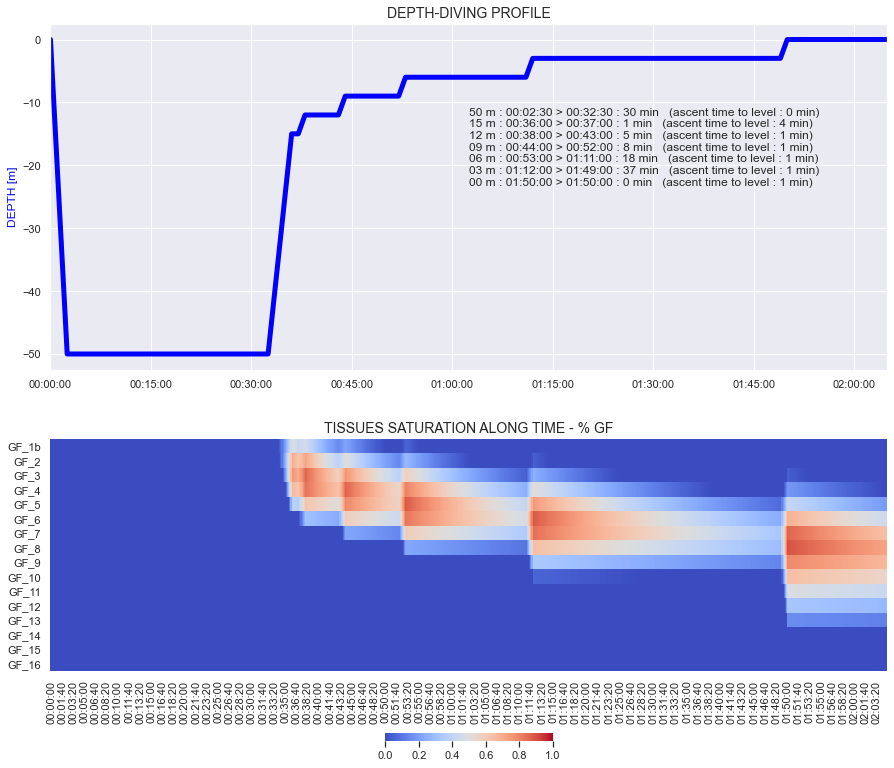

In [19]:
cells = list(M_values.keys())
for cell in cells:
    col_name = "pN2_cell_" + cell + " [bar]"
    M0 = M_values[cell]['M0']
    M_slope = M_values[cell]['M_Slope']
    df2["GF_" + cell] = df2.apply(lambda x: max(0, (x[col_name] - x['Ambiant Pressure [bar]']) / (M0 + M_slope * (x['Ambiant Pressure [bar]'] - p_atm_sea_level) - x['Ambiant Pressure [bar]'])), axis = 1)

df_c = df2[['Time'] + [c for c in df2.columns if (c.startswith("GF"))]]
df_c = df_c.loc[(df_c['Time'].dt.second % 10) == 0]
df_c.index = df_c['Time'].dt.time
df_c = df_c[[c for c in df_c.columns if c not in 'Time']].transpose()

txt = ""
for i in range(len(deco_planner)):
    depth = deco_planner['Depth [m]'].iloc[i]
    tmin = deco_planner['Time - min'].iloc[i]
    tmax = deco_planner['Time - max'].iloc[i]    
    ascent_duration = deco_planner['Ascent duration'].iloc[i]
    duration = deco_planner['Duration at depth'].iloc[i]  
    txt += str(round(depth)).zfill(2) + " m : " + str(tmin) + " > " + str(tmax) + " : " + str(duration) + " min   " + "(ascent time to level : " + str(ascent_duration) + " min)" + "\n"


fig, axs = plt.subplots(2, 1, figsize = (15, 14))
axs[0].plot(df2['Time'], -df2['Depth [m]'], linewidth = 5, c = "blue")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[0].set_ylabel('DEPTH [m]', fontsize = 12, color = "blue")
axs[0].set_xlim(df2['Time'].min(), df2['Time'].max()) 
axs[0].set_title('DEPTH-DIVING PROFILE', fontsize = 14)
axs[0].text(x = df2['Time'].iloc[0] + (df2['Time'].iloc[-1] - df2['Time'].iloc[0]) * 0.5, y = (-df2['Depth [m]'].max())/2, s = txt, fontsize=12)
sns.heatmap(df_c, vmin = 0, vmax = 1, cmap = "coolwarm", ax = axs[1], cbar_kws = {'location' : "bottom", 'pad' : 0.18, 'shrink' : 0.2})
axs[1].set_title('TISSUES SATURATION ALONG TIME - % GF', fontsize = 14)
axs[1].set(xlabel = None)
plt.savefig('deco.pdf')
#plt.show()

<ipython-input-20-4112add817fe>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, 1].set_xticklabels(df2['Time'], rotation = 30)


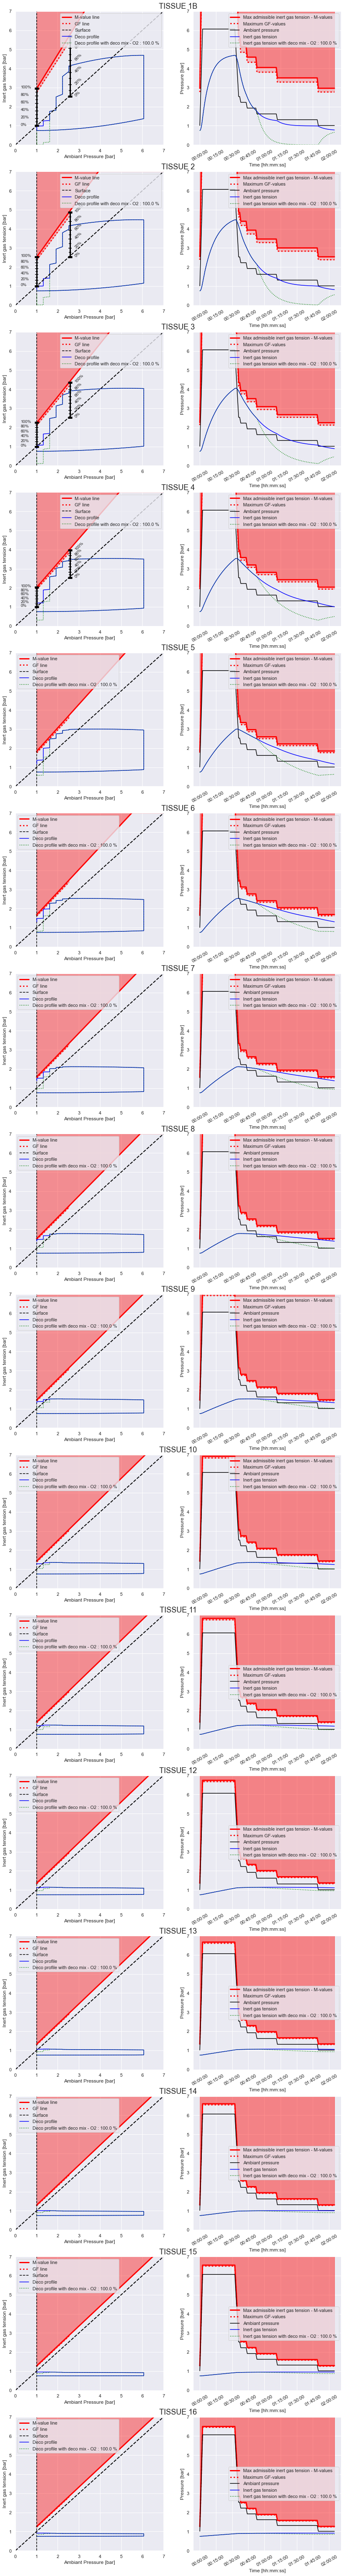

In [20]:
cells = list(M_values.keys())
fig, axs = plt.subplots(len(cells), 2, figsize = (14, 7 * len(cells)))
i = 0
for cell in cells:
    col_name = "pN2_cell_" + cell + " [bar]"
    M0 = M_values[cell]['M0']
    M_slope = M_values[cell]['M_Slope']
    Pamb_first_deco_stop = pressure_at_depth(first_deco_stop)
    x = [i for i in range(1, 8)]
    M_line = [(p - p_atm_sea_level) * M_slope + M0 for p in x]

    axs[i, 0].plot(x, M_line, color = 'red', linewidth = 3, label = "M-value line")
    
    GF_x1 = np.array([p_atm_sea_level, p_atm_sea_level + (M0 - p_atm_sea_level) * GF_high])
    GF_x2 = np.array([Pamb_first_deco_stop, (M0 + M_slope * (Pamb_first_deco_stop - p_atm_sea_level) - Pamb_first_deco_stop) * GF_low + Pamb_first_deco_stop])
    
    axs[i, 0].plot([GF_x1[0], GF_x2[0]], [GF_x1[1], GF_x2[1]], color = 'red', linestyle = 'dotted', linewidth = 3, label = "GF line")
    axs[i, 0].plot([1., 1.], [0., 7.], linestyle = '--', color = 'black', label = "Surface")
    axs[i, 0].plot(df2['Ambiant Pressure [bar]'], df2[col_name], color = 'blue', label = "Deco profile")
    axs[i, 0].plot(df2['Ambiant Pressure [bar]'], df2["pN2_cell_" + cell + " [bar]_deco"], color = 'green', linestyle = 'dotted', label = "Deco profile with deco mix - O2 : " + str(np.round(O2Part_Deco * 100)) + " %")
    axs[i, 0].set_xlabel('Ambiant Pressure [bar]')
    axs[i, 0].set_ylabel('Inert gas tension [bar]')
    axs[i, 0].set_xlim([0., 7.])
    axs[i, 0].set_ylim([0., 7.])
    axs[i, 0].plot([0., 7.], [0., 7.], color = 'black', linestyle = '--', linewidth = 2)
    axs[i, 0].set_title("TISSUE " + cell.upper(), fontsize = 18)
    axs[i, 0].fill_between([GF_x1[0], GF_x2[0]], [GF_x1[1], GF_x2[1]], [M0, M0 + M_slope * (Pamb_first_deco_stop - p_atm_sea_level)], linewidth = 2., color = 'red', alpha = 0.2)
    axs[i, 0].fill_between(x, M_line, 7., color = 'red', alpha = 0.4)
    ttl = axs[i, 0].title
    ttl.set_position([1.1, 1.2])
    axs[i, 0].legend()
    
    if (i < 4):
        x1 = np.array([Pamb_first_deco_stop, Pamb_first_deco_stop])
        M_value = M0 + M_slope * (Pamb_first_deco_stop - p_atm_sea_level)
        x2 = np.array([Pamb_first_deco_stop, M_value])
        axs[i, 0].plot([x1[0] + 0.05, x2[0] + 0.05], [x1[1], x2[1]], color = 'black', linewidth = 3, marker = '_', markersize = 10, markeredgewidth = 5)
        for k in range(0, 11, 1):
            x1_marker = x1 + (x2 - x1) * (k/10)
            if (k%2 == 0):
                axs[i, 0].scatter([x1_marker[0] + 0.05], [x1_marker[1]], marker = '_', color = 'black', s = 50)
                axs[i, 0].text(x1_marker[0] + 0.25, x1_marker[1], str(k*10) + "%", fontsize = 10, rotation = 45)
            else:
                axs[i, 0].scatter([x1_marker[0] + 0.05], [x1_marker[1]], marker = '_', color = 'black', s = 30)

        x1 = np.array([1., 1.])
        x2 = np.array([1, M0])
        axs[i, 0].plot([x1[0], x2[0]], [x1[1], x2[1]], color = 'black', linewidth = 3, marker = '_', markersize = 10, markeredgewidth = 5)
        for z in range(0, 11, 1):
            x1_marker = x1 + (x2 - x1) * (z/10)
            if (z%2 == 0):
                axs[i, 0].scatter([x1_marker[0]], [x1_marker[1]], marker = '_', color = 'black', s = 50)
                axs[i, 0].text(x1_marker[0] - 0.75, x1_marker[1], str(z*10) + "%", fontsize = 10)        
            else:
                axs[i, 0].scatter([x1_marker[0]], [x1_marker[1]], marker = '_', color = 'black', s = 30)
       
    M_val_lim = (df2['Ambiant Pressure [bar]'] - p_atm_sea_level) * M_slope + M0
    p_first_deco_stop = p_atm_sea_level + (first_deco_stop * rho_water * g) / 1E5
    x2 = p_first_deco_stop
    y2 = p_first_deco_stop + GF_low * (M0 + M_slope * (p_first_deco_stop - p_atm_sea_level) - p_first_deco_stop)
    x1 = p_atm_sea_level
    y1 = p_atm_sea_level + (M0 - p_atm_sea_level) * GF_high
    M_val_lim_gf = ((y2 - y1) / (x2 - x1)) * (df2['Ambiant Pressure [bar]'] - p_atm_sea_level) + y1
    axs[i, 1].plot(df2['Time'], M_val_lim, color = 'red', linewidth = 3, label = "Max admissible inert gas tension - M-values")
    axs[i, 1].plot(df2['Time'], M_val_lim_gf, color = 'red', linewidth = 3, linestyle = 'dotted', label = "Maximum GF-values")
    axs[i, 1].plot(df2['Time'], df2['Ambiant Pressure [bar]'], color = 'black', label = "Ambiant pressure")
    axs[i, 1].plot(df2['Time'], df2[col_name], color = 'blue', label = "Inert gas tension")
    axs[i, 1].plot(df2['Time'], df2["pN2_cell_" + cell + " [bar]_deco"], color = 'green', linestyle = 'dotted', label = "Inert gas tension with deco mix - O2 : " + str(np.round(O2Part_Deco * 100, 0)) + " %")
    axs[i, 1].set_xticklabels(df2['Time'], rotation = 30)
    axs[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    axs[i, 1].fill_between(df2['Time'], M_val_lim_gf, 100., color = 'red', alpha = 0.2)
    axs[i, 1].fill_between(df2['Time'], M_val_lim, 100., color = 'red', alpha = 0.3)
    axs[i, 1].set_xlabel('Time [hh:mm:ss]')
    axs[i, 1].set_ylabel('Pressure [bar]')
    axs[i, 1].set_ylim([0., 7.])
    axs[i, 1].legend()   
    i += 1

plt.savefig("deco_profile.pdf")